In [28]:
import sys
sys.path.append('../') # To import from parent dir
import os
import ast

import pandas as pd
from itertools import chain

from util.GrammarBasedUtil import *

import matplotlib.pyplot as plt

In [29]:
# ---- Initialize all context parameters that will be used ----
# Note: Read the alignment hints above
systems = ["category"]
applications = ["application"]
uiGroup1 = ["workbook","browser_url","title"]
uiGroup2 = ["current_worksheet"] 
uiGroup3 = ["cell_range","cell_range_number"]
uiElement = ["mouse_coord","tag_category","xpath","event_src_path","event_dest_path","tag_name","tag_title","tag_href",
             "tag_innerText","tab_pinned","tab_audible","tab_muted","window_ingognito","tab_moved_from_index","tab_moved_to_index","id"]
actions = ["concept:name","eventQual"]

# ---- Add all hierarchy levels into a list ----
hierarchy_list_smartrpa = [systems, applications, uiGroup1, uiGroup2, uiGroup3, uiElement, actions]
hierarchy_columns_smartrpa = list(chain.from_iterable([h for h in hierarchy_list_smartrpa if h]))

# ---- Define the path in which all files are stored ----
folder_path_smartRPA = "../logs/smartRPA/percentageComparison/"

percentagData_filename = "validationDataPercentage.csv"

# ---- Getting the relevant files from the folder and sorting them into different lists for processing ----
isSmartRPA = True
sep_smartrpa = ","
percentageLogs = []

for file in os.listdir(folder_path_smartRPA):
    if file.startswith("LenLog"):
        percentageLogs.append(file)

# Check if data created for percentage based comparison is available
try:
    percentageValData = pd.read_csv(folder_path_smartRPA + percentagData_filename)
    percentageValAvailable = True
except FileNotFoundError as e:
    print(f"Could not read {percentagData_filename} from the folder.\n{e}")
    percentageValAvailable = False

In [30]:
# ---- Define the path in which all files are stored ----
folder_path_leno = "../logs/leno/"

sep_leno = ";"
leno_SR_RT_plus = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus.csv", sep=sep_leno)
# leno_SR_RT_plus_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus_ground_truth.csv", sep=sep_leno)
# leno_SR_RT_parallel = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel.csv", sep=sep_leno)
# leno_SR_RT_parallel_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel_ground_truth.csv", sep=sep_leno)

# ---- Initialize all context parameters that will be used ----
# Note: Read the alignment hints above
systems = []
applications = ["targetApp"]
uiGroup1 = ["url","target.workbookName"]
uiGroup2 = ["target.sheetName"]
uiElement = ["target.id","target.tagName","target.type","target.name","target.href"]
actions = ["eventType"]

# ---- Add all hierarchy levels into a list ----
hierarchy_list_leno = [applications, uiGroup1, uiGroup2, uiElement, actions]
# Flatten the hierarchy list and remove empty lists
hierarchy_columns_leno = list(chain.from_iterable([h for h in hierarchy_list_leno if h]))

Encoding of unique subsequences - Counting their overall occurances in the log

In [37]:
# Agostinelli
hierarchy_columns = hierarchy_columns_smartrpa
log_name_smartRPA = percentageLogs[6]
file = pd.read_csv(folder_path_smartRPA + log_name_smartRPA, sep=sep_smartrpa)
log = symbolize_UILog(file, hierarchy_columns)
print(f"Processing file: {log_name_smartRPA} with {len(log)} events.")
comparisonVariables = percentageValData.loc[percentageValData['uiLogName'] == log_name_smartRPA]
insertSpots = comparisonVariables["motifSpots"]
parsed_spots = insertSpots.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
insert_spots_flat = [int(i) for sublist in parsed_spots for i in sublist]
insert_spots_set = set(insert_spots_flat)
print(f"{len(insert_spots_set)} insertion spots.")

# Leno
# hierarchy_columns = hierarchy_columns_leno
# log = symbolize_UILog(leno_SR_RT_plus, hierarchy_columns)

encoding_df, symbols, two_gram_df = re_pair(log)
# Test of decoding for last symbol (should be longest)
last_entry = len(encoding_df["new_symbol"])-1
last_encoding = encoding_df["new_symbol"].iloc[last_entry]
print("\n Last Encoded Entry: ",last_encoding)
decoded_symbol = re_pair_decode_symbol(last_encoding, encoding_df, printing=True)

Processing file: LenLog_1_10_1_10_15_2-5_6000.csv with 6000 events.
10 insertion spots.
18  unique pairs found so far. Level:  1
28  unique pairs found so far. Level:  2
34  unique pairs found so far. Level:  3
36  unique pairs found so far. Level:  4

 Last Encoded Entry:  aj
aj → (t, ad)
  t → (c, e)
    c → (HKB, GYM)
      HKB → [base symbol]
      GYM → [base symbol]
    e → (HQF, HQB)
      HQF → [base symbol]
      HQB → [base symbol]
  ad → (v, aa)
    v → (l, a)
      l → (HJA, HQB)
        HJA → [base symbol]
        HQB → [base symbol]
      a → (GJN, GQP)
        GJN → [base symbol]
        GQP → [base symbol]
    aa → (m, k)
      m → (HJB, GVI)
        HJB → [base symbol]
        GVI → [base symbol]
      k → (GZF, HBI)
        GZF → [base symbol]
        HBI → [base symbol]

Decoding path for symbol 'aj':
Final expansion: ['HKB', 'GYM', 'HQF', 'HQB', 'HJA', 'HQB', 'GJN', 'GQP', 'HJB', 'GVI', 'GZF', 'HBI']



In [32]:
# Initialize the count column
log["rule_density_count"] = 0
for i, rule in encoding_df.iterrows():
    decoding = re_pair_decode_symbol(rule["new_symbol"], encoding_df, printing=False) 
    # Sliding window search for the sequence
    seq_len = len(decoding)
    symbols = log["symbol"].astype(str).tolist()
    for i in range(len(symbols) - seq_len + 1):
        if symbols[i:i + seq_len] == decoding:
            log.loc[i:i + seq_len - 1, "rule_density_count"] += 1

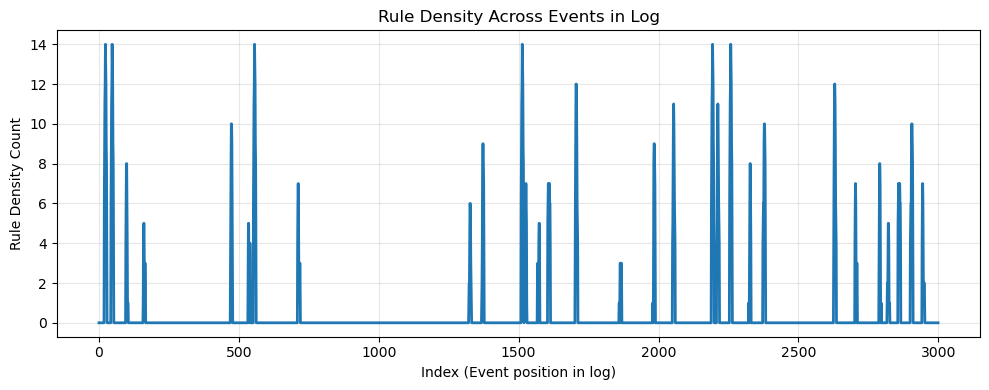

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(log.index, log["rule_density_count"], linewidth=2)
plt.title("Rule Density Across Events in Log")
plt.xlabel("Index (Event position in log)")
plt.ylabel("Rule Density Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
log[log["rule_density_count"]>10]

,Unnamed: 0,case:concept:name,case:creator,lifecycle:transition,time:timestamp,org:resource,category,application,concept:name,event_src_path,...,tag_html,tag_href,tag_innerText,tag_option,tag_attributes,xpath,xpath_full,symbol,count,rule_density_count
21,49202,620204817000000,SmartRPA by marco2012,complete,2020-06-20T20:49:40.000,michael99,Browser,Chrome,clickRadioButton,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""chair/image[3]"")","id(""chair/image[3]"")",AAP,30,11
22,49203,620204817000000,SmartRPA by marco2012,complete,2020-06-20T20:50:31.000,michael99,Browser,Chrome,installBrowserExtension,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""hope"")","id(""hope"")",AWS,30,12
23,49204,620204817000000,SmartRPA by marco2012,complete,2020-06-20T20:51:07.000,michael99,Browser,Chrome,clickRadioButton,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""hope"")","id(""hope"")",AAR,30,14
24,49205,620204817000000,SmartRPA by marco2012,complete,2020-06-20T20:51:32.000,michael99,Browser,Chrome,clickLink,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""hope"")","id(""hope"")",BAC,30,13
25,49206,620204817000000,SmartRPA by marco2012,complete,2020-06-20T20:52:04.000,michael99,Browser,Chrome,installBrowserExtension,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""chair/image[3]"")","id(""chair/image[3]"")",AAQ,30,12
45,49202,620204817000000,SmartRPA by marco2012,complete,2020-06-20T20:49:40.000,michael99,Browser,Chrome,clickRadioButton,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""chair/image[3]"")","id(""chair/image[3]"")",AAP,30,11
46,49203,620204817000000,SmartRPA by marco2012,complete,2020-06-20T20:50:31.000,michael99,Browser,Chrome,installBrowserExtension,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""hope"")","id(""hope"")",AWS,30,12
47,49204,620204817000000,SmartRPA by marco2012,complete,2020-06-20T20:51:07.000,michael99,Browser,Chrome,clickRadioButton,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""hope"")","id(""hope"")",AAR,30,14
48,49205,620204817000000,SmartRPA by marco2012,complete,2020-06-20T20:51:32.000,michael99,Browser,Chrome,clickLink,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""hope"")","id(""hope"")",BAC,30,13
49,49206,620204817000000,SmartRPA by marco2012,complete,2020-06-20T20:52:04.000,michael99,Browser,Chrome,installBrowserExtension,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""chair/image[3]"")","id(""chair/image[3]"")",AAQ,30,12
